In [16]:
import dynamiqs as dq
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import jax as jax

# importing and defining necessary boundaries
PI = np.pi


dq.plot.mplstyle(dpi=150)  

In [2]:
def ncat(n, alpha, dim): # function that returns an n-Cat state with a given phase alpha
    cat = dq.coherent(dim, alpha)
    for k in range(1, n):
        cat += dq.coherent(dim, jnp.exp(2j*jnp.pi*k/n)*alpha)
    return cat/dq.norm(cat)

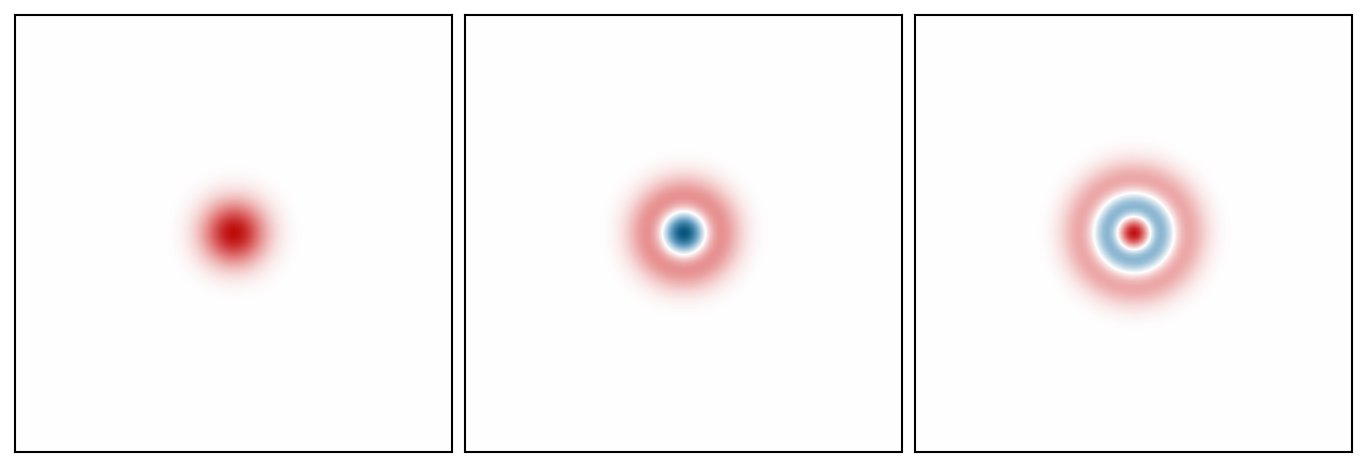

In [26]:
#generate and plot the first three fock states in a mosaic, for single plots use dq.plot.wigner()
fockstates = [dq.fock(3, i) for i in range(3)] 

dq.plot.wigner_mosaic(fockstates)

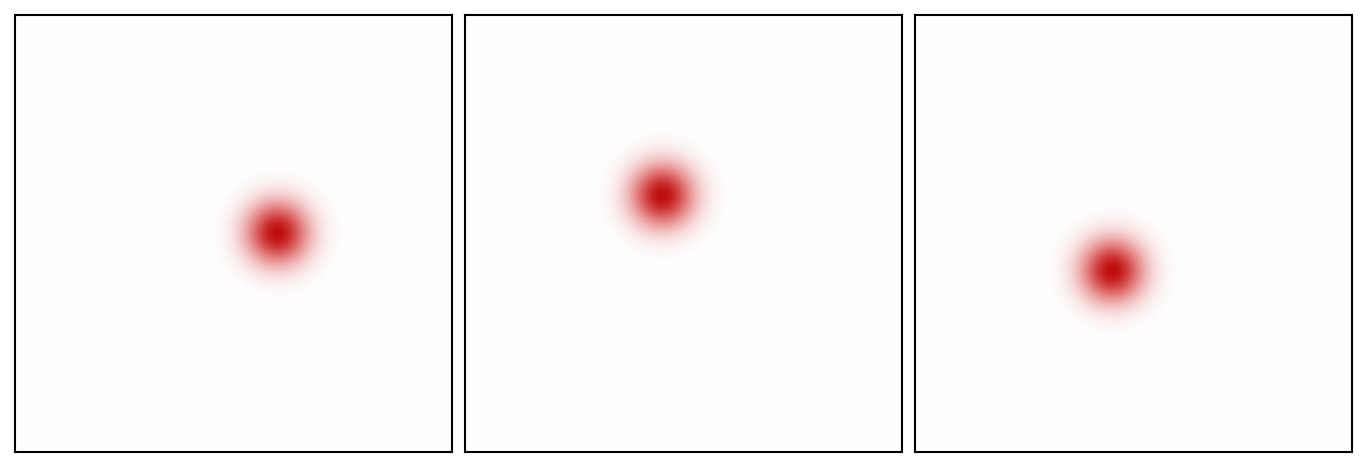

In [4]:
#generate and plot three coherent states in a mosaic, for single plots use dq.plot.wigner()
coherentstates = [dq.coherent(10, np.exp(2j *PI/3 * i)) for i in range(3)]
dq.plot.wigner_mosaic(coherentstates)

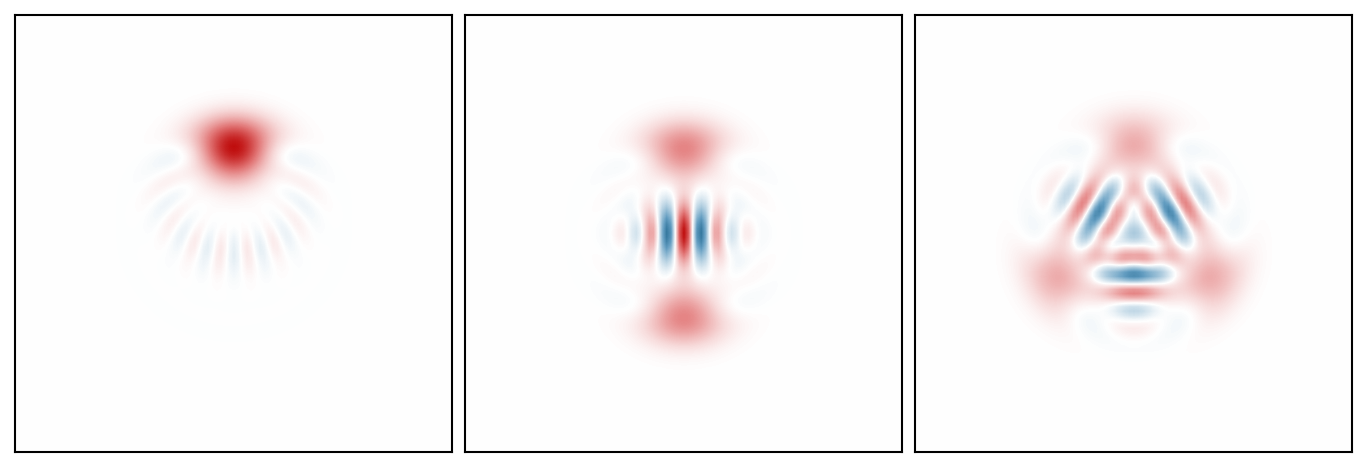

In [87]:
#generate and plot three cat states in a mosaic, for single plots use dq.plot.wigner()
catstates = [ncat(i, 2*np.exp(1j *PI/2), 10) for i in range(1,4)]
dq.plot.wigner_mosaic(catstates)


In [6]:
#here we define the problem posed in 1a and plot the timeevolution of our vacuum state with the lindtblattian
a, b = dq.destroy(10, 10)
g2 = 1
eps = -4
kappa = 10
T = 4
ntsave = 201
rho = dq.fock_dm((10,10),(0,0))
H = np.conj(g2)*(a.dag() @ a.dag() @ b) + g2*(a @ a @ b.dag()) + np.conj(eps)*b+ eps*b.dag()
jump_ops = [b]
tsave = jnp.linspace(0.0, T, ntsave)
result = dq.mesolve(H, jump_ops, rho, tsave)
gif = dq.plot.wigner_gif(result.states, ymax=3.0, gif_duration=4.0)

|████████████████████████████████████████████████████████████████████████| 100.0% ◆ elapsed 152.04ms ◆ remaining 0.00ms
100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.48it/s]


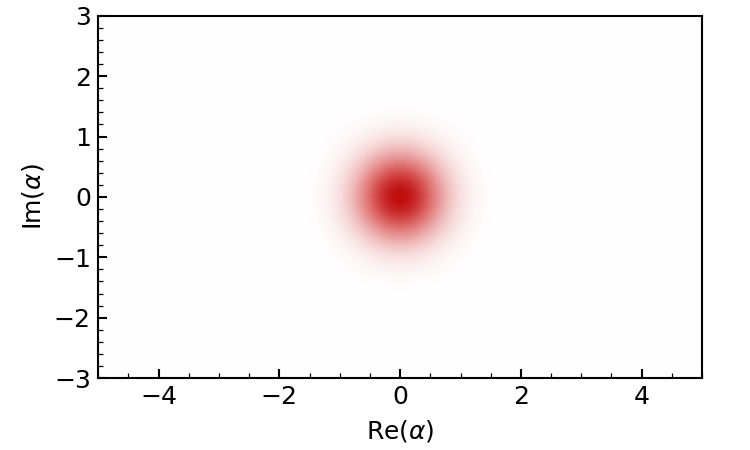

In [7]:
gif

In [8]:


def wigner_from_state(rho_in,
           x_vec, y_vec):
    
    xv, yv = jnp.meshgrid(x_vec, y_vec)
    #Define Wigner Function
    def w(state, xv, xy):
        return jnp.pi/2*dq.wigner(state, xmax = xv.max(), ymax = yv.max(), npixels = len(xv))[2]
    
    #============================================================
    #Define Preliminary Data
    dim = rho_in.dims[0]
    fac = 10
    
    #Check if dim has correct properties:
    if type(dim)!=int:
        raise('Dimension is not integer')
    
    #Compute measurement data
    w_k = w(rho_in, xv, yv).flatten()
    
    #Define Observables
    alpha = (xv.T + yv.T*1j).flatten()
    E_list = (dq.displace(dim*fac, alpha)@dq.parity(dim*fac)@dq.dag(dq.displace(dim*fac, alpha))).data[:, :dim, :dim]
    
    #===============================================================
    #Inititalize Optimization
    
    # Define variable
    rho = cp.Variable((dim, dim), hermitian=True)
    
    # Objective
    exprs = cp.hstack([cp.real(cp.trace(E@rho)) - k for E, k in zip(E_list, w_k)])
    objective = cp.Minimize(cp.sum_squares(exprs))
    # print(objective)
    
    # Constraints
    constraints = [rho >> 0, cp.trace(rho) == 1]
    
    # Solve problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.MOSEK)
    
    # Output estimated density matrix
    rho_out = rho.value
    #Compute Fidelity
    fidelity = dq.fidelity(rho_in, rho_out)
    
    return rho_out, fidelity



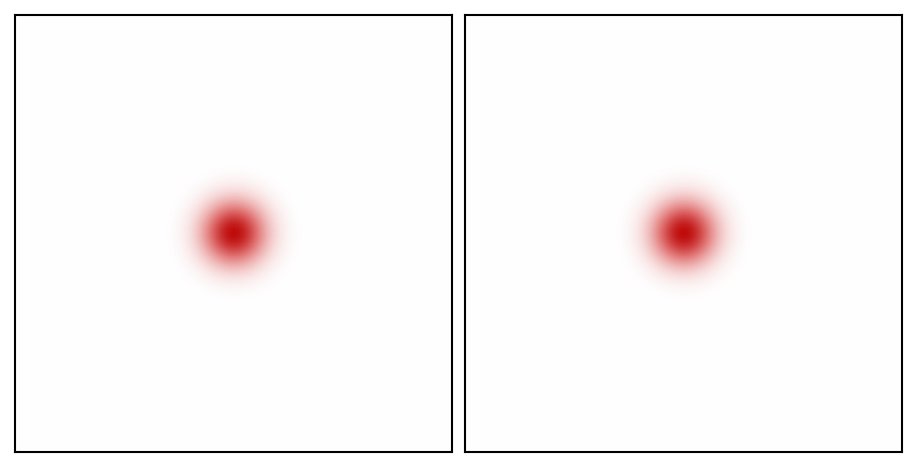

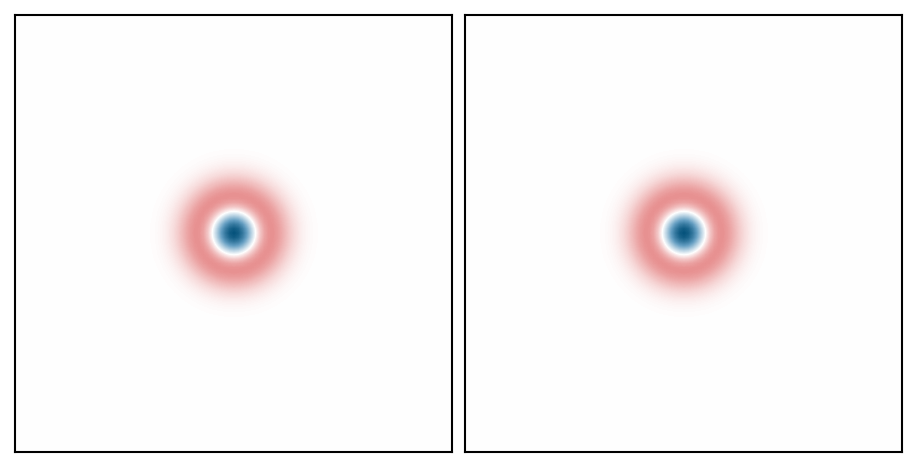

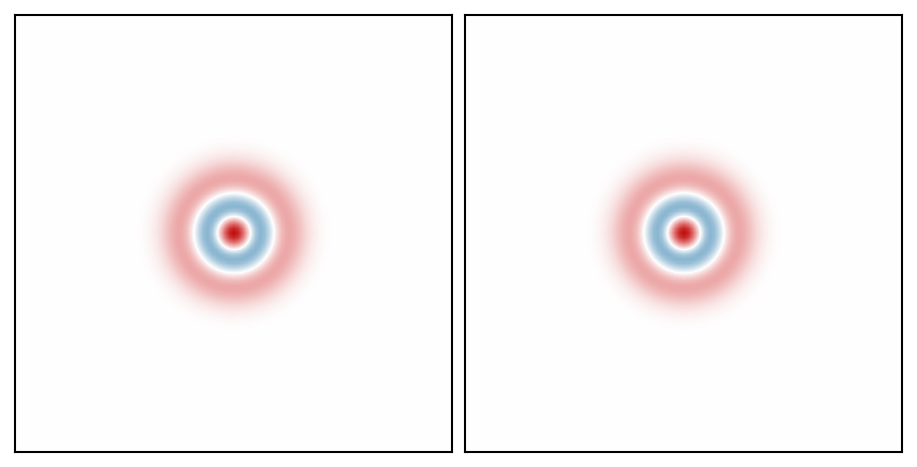

In [27]:
x_vec = jnp.linspace(-2, 2, 10)
y_vec = jnp.linspace(-2, 2, 10)
for fock_state in fockstates:
    rho_out, fidelity = wigner_from_state(fock_state, x_vec, y_vec)
    states = [fock_state@dq.dag(fock_state), rho_out]
    dq.plot.wigner_mosaic(states)



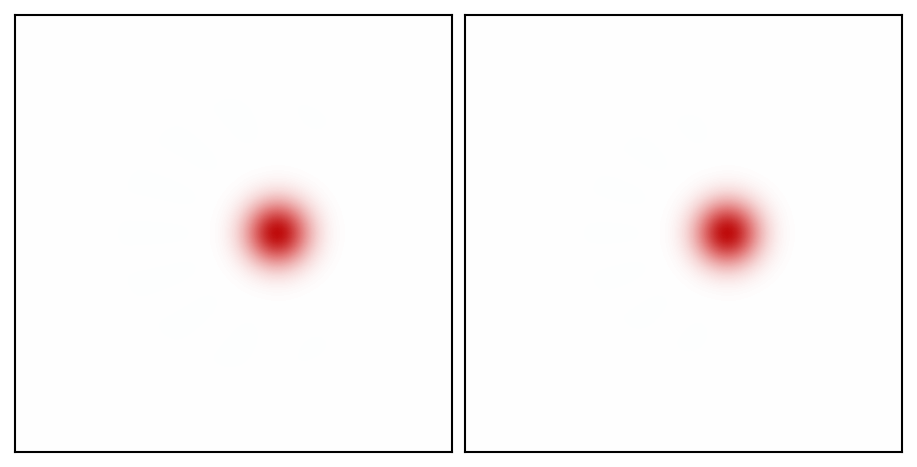

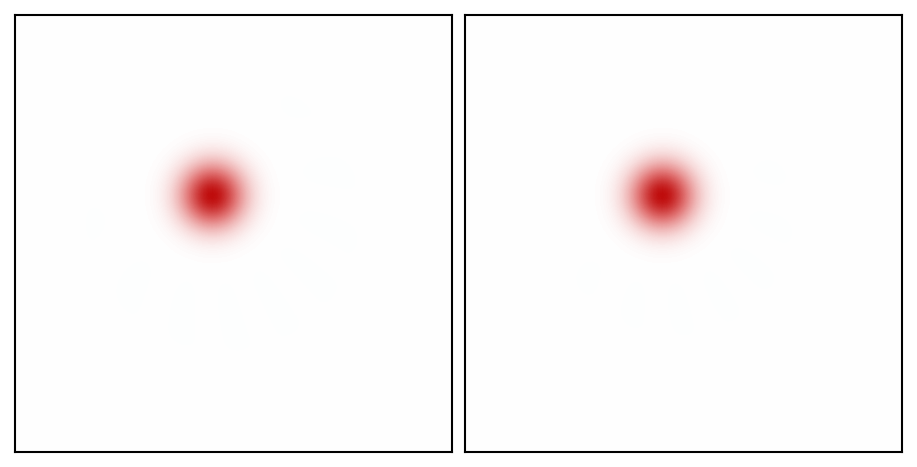

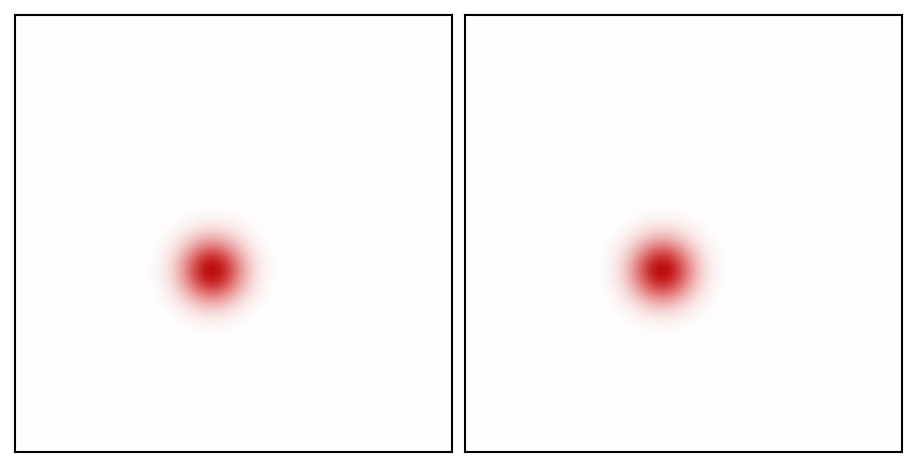

In [10]:
for coherent_state in coherentstates:
    rho_out, fidelity = wigner_from_state(coherent_state, x_vec, y_vec)
    states = [coherent_state@dq.dag(coherent_state), rho_out]
    dq.plot.wigner_mosaic(states)

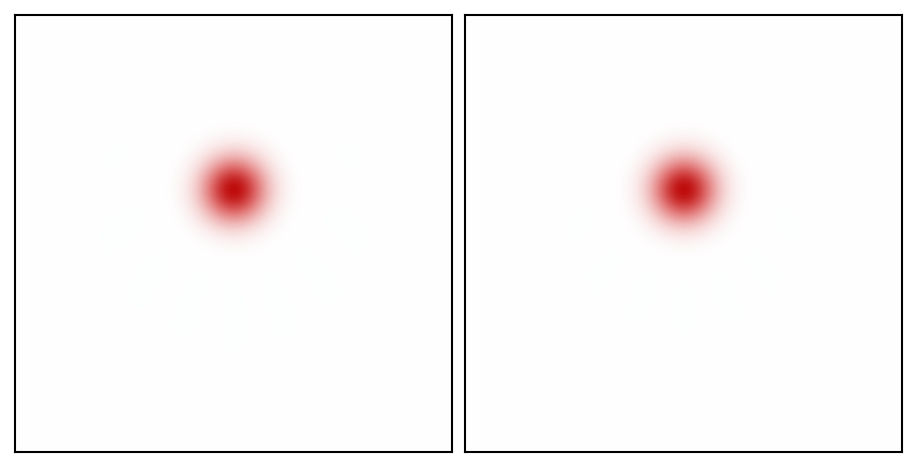

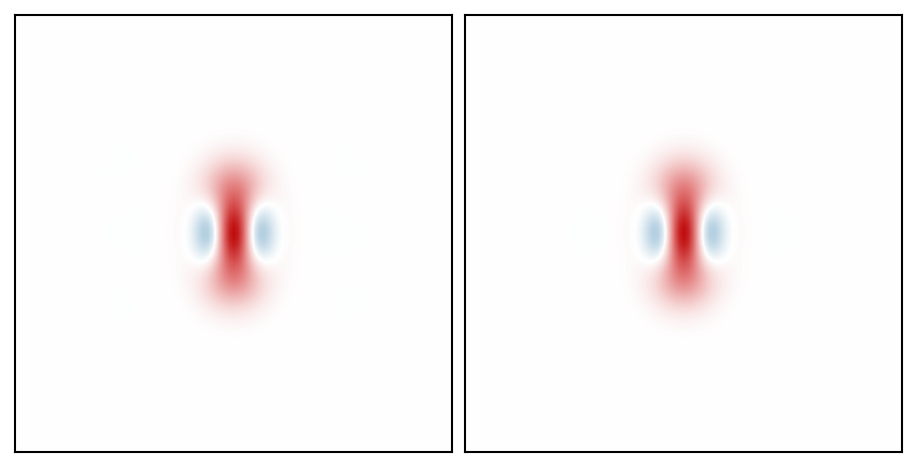

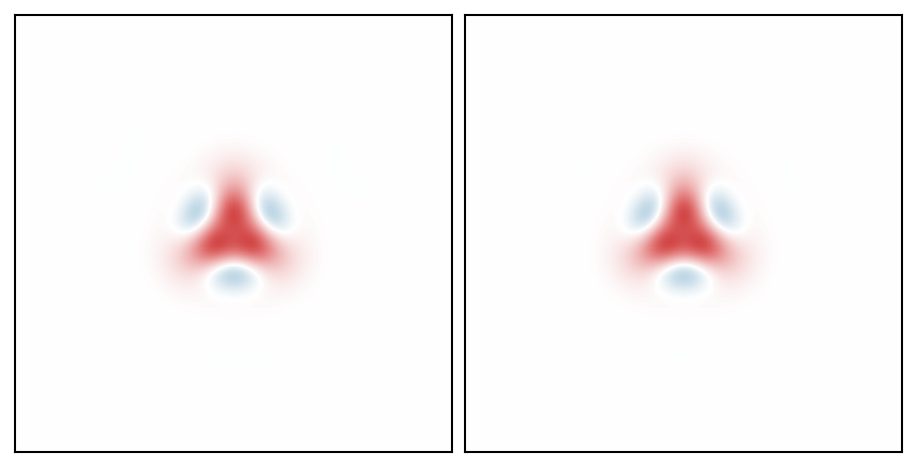

In [11]:
for cat_state in catstates:
    rho_out, fidelity = wigner_from_state(cat_state, x_vec, y_vec)
    states = [cat_state@dq.dag(cat_state), rho_out]
    dq.plot.wigner_mosaic(states)

In [56]:
def add_gaussian_noise(wigner, sigma, axes):
    noise = sigma*jax.random.normal(jax.random.key(0), wigner.shape)
    axes[1].imshow(jnp.add(wigner, noise), cmap="bwr", vmax=1, vmin=-1)
    axes[1].xaxis.set_ticklabels([])
    axes[1].yaxis.set_ticklabels([])
    return jnp.add(wigner, noise)

def wigner_from_state_wnoise(rho_in,
           xv, yv,
           sigma,
            axes,
           optimization_type = 'Least-Squares'
                            ):
    
    xv, yv = jnp.meshgrid(x_vec, y_vec)
    #Define Wigner Function
    def w(state, xv, xy):
        return jnp.pi/2*dq.wigner(state, xmax = xv.max(), ymax = yv.max(), npixels = len(xv))[2]
        
    #============================================================
    #Define Preliminary Data
    dim = rho_in.dims[0]
    if dim<5:
        fac = 10
    else:
        fac = 5
    
    #Check if dim has correct properties:
    if type(dim)!=int:
        raise('Dimension is not integer')
    
    #Compute measurement data
    w_k = add_gaussian_noise(w(rho_in, xv, yv), sigma, axes).flatten()
    
    #Define Observables
    alpha = (xv.T + yv.T*1j).flatten()
    E_list = (dq.displace(dim*fac, alpha)@dq.parity(dim*fac)@dq.dag(dq.displace(dim*fac, alpha))).data[:, :dim, :dim]
    
    #===============================================================
    #Inititalize Optimization
    
    # Define variable
    rho = cp.Variable((dim, dim), hermitian=True)
    
    # Objective
    exprs = cp.hstack([cp.real(cp.trace(E@rho)) - k for E, k in zip(E_list, w_k)])
    
    if optimization_type == 'Least-Squares':
        objective = cp.Minimize(cp.sum_squares(exprs))
    if optimization_type == 'Huber':
        objective = cp.Minimize(cp.sum(cp.huber(exprs)))
    
    # print(objective)
    
    # Constraints
    constraints = [rho >> 0, cp.trace(rho) == 1]
    
    # Solve problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.MOSEK)
    
    # Output estimated density matrix
    rho_out = rho.value
    #Compute Fidelity
    fidelity = dq.fidelity(rho_in, rho_out)
    
    return rho_out, fidelity

0.96645665
0.9623491
0.9984446


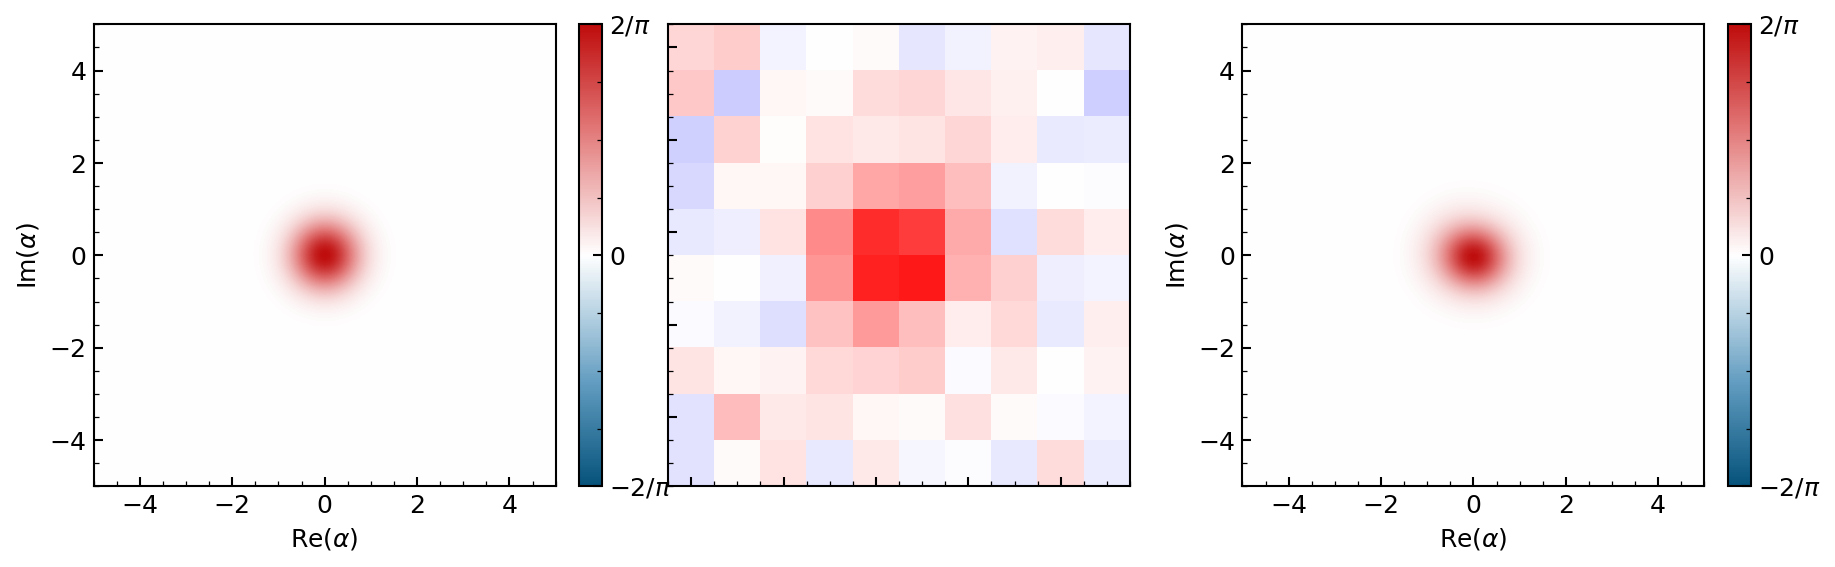

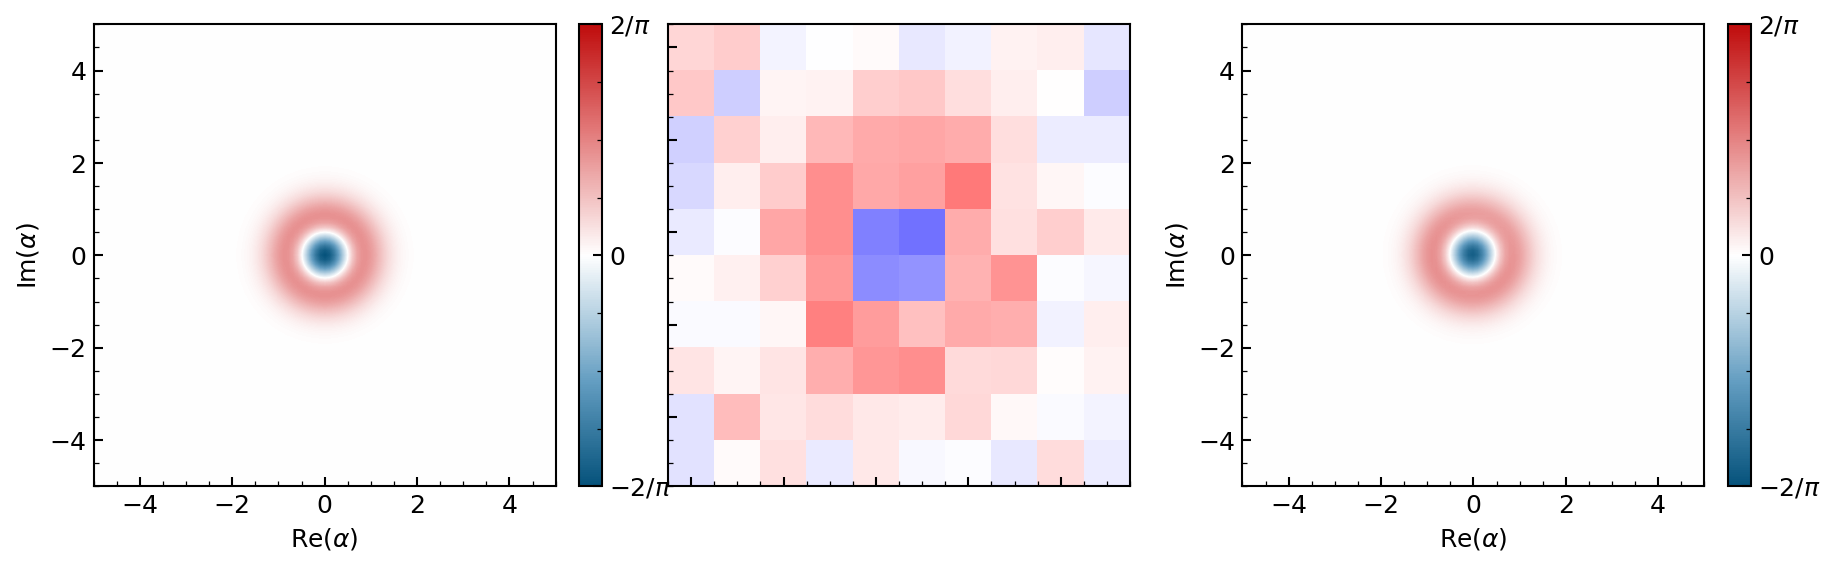

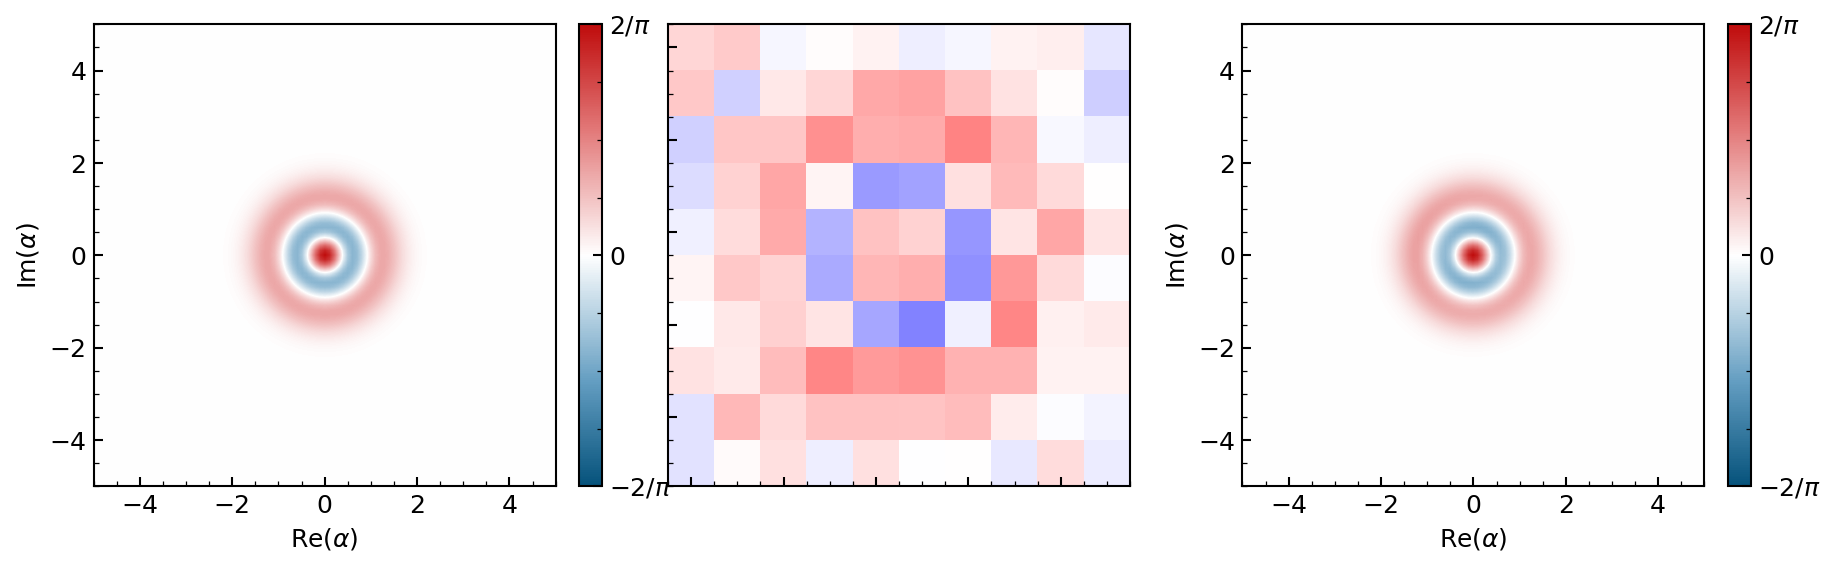

In [57]:
x_vec = jnp.linspace(-2, 2, 10)
y_vec = jnp.linspace(-2, 2, 10)
sigma_test = 0.1
for fock_state in fockstates:
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    dq.plot.wigner(fock_state, ax=axes[0])
    
    rho_out, fidelity = wigner_from_state_wnoise(fock_state, x_vec, y_vec, sigma_test, axes)
    states = [fock_state@dq.dag(fock_state), rho_out]
    dq.plot.wigner(rho_out, ax=axes[2])
    print(fidelity)

0.9182398
0.8575835
0.8898287


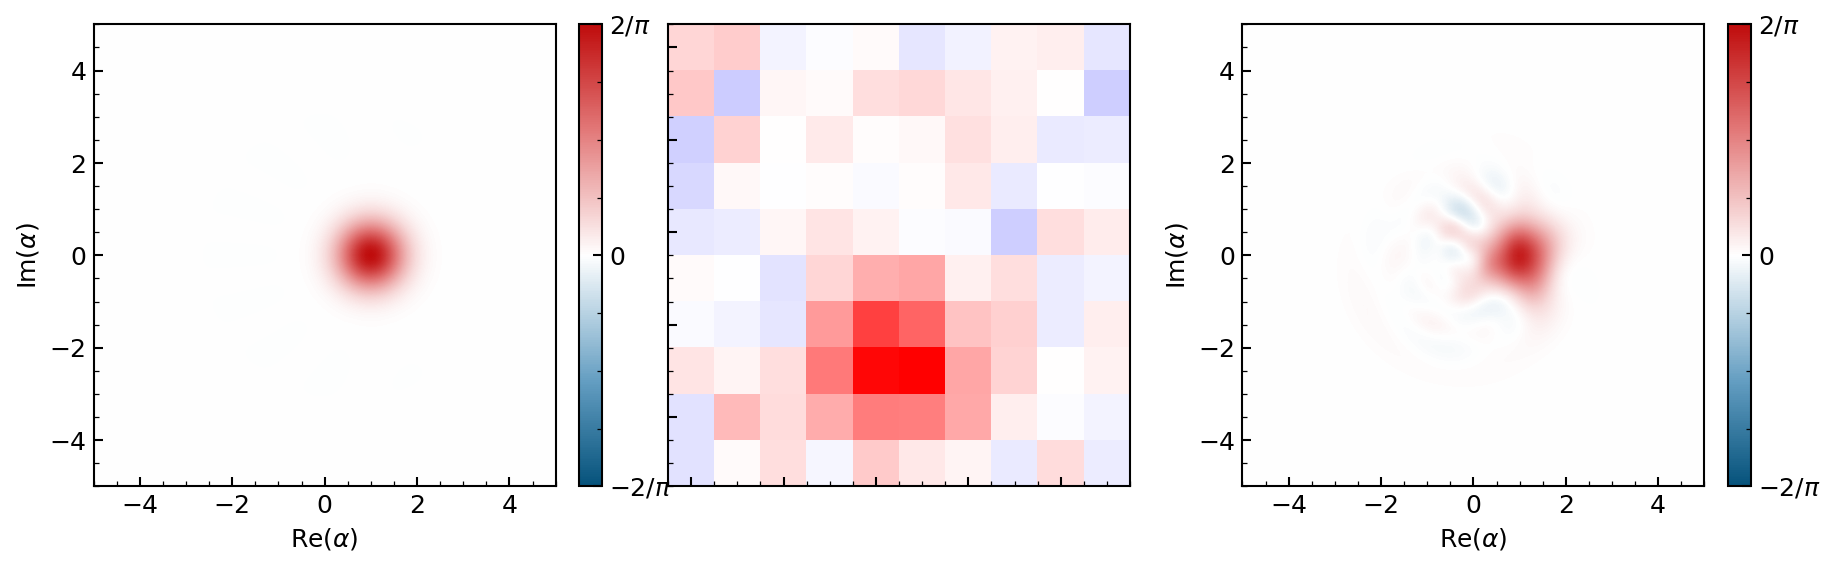

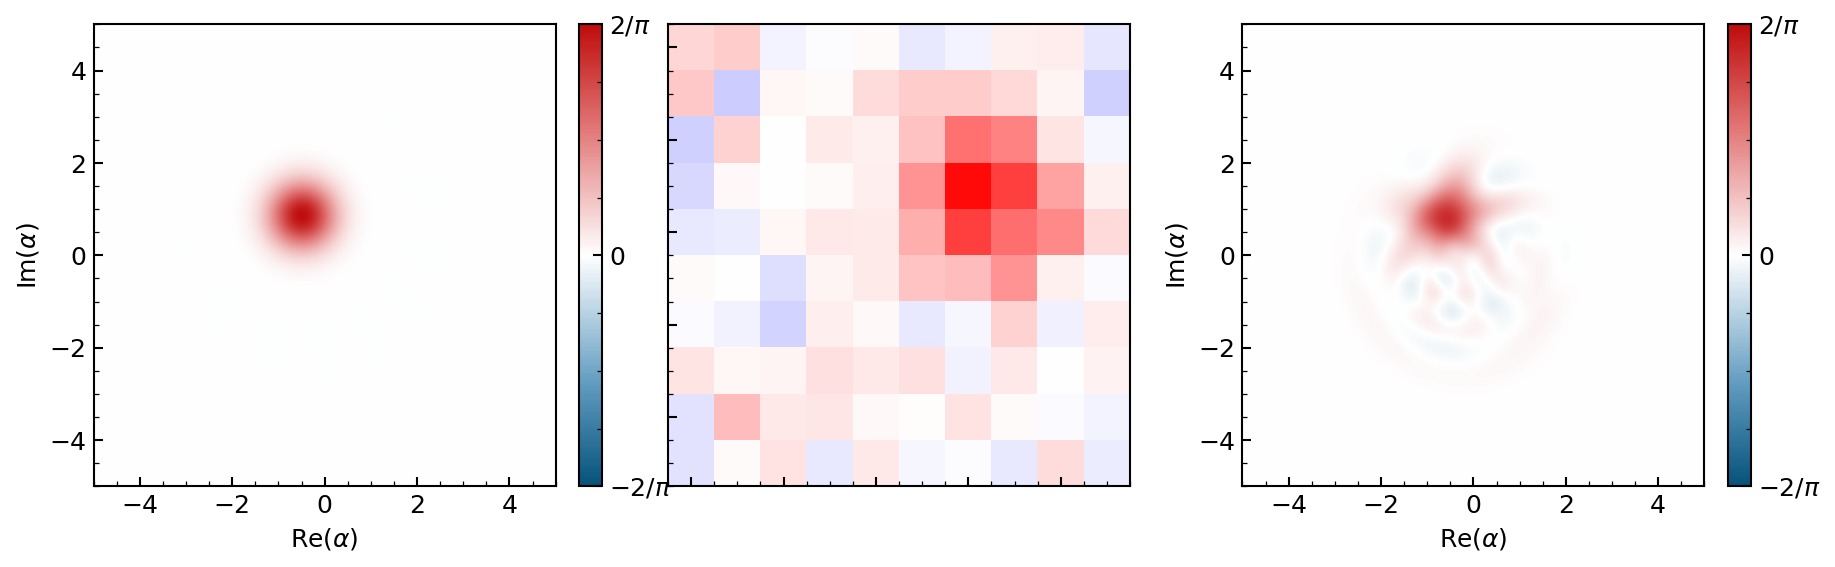

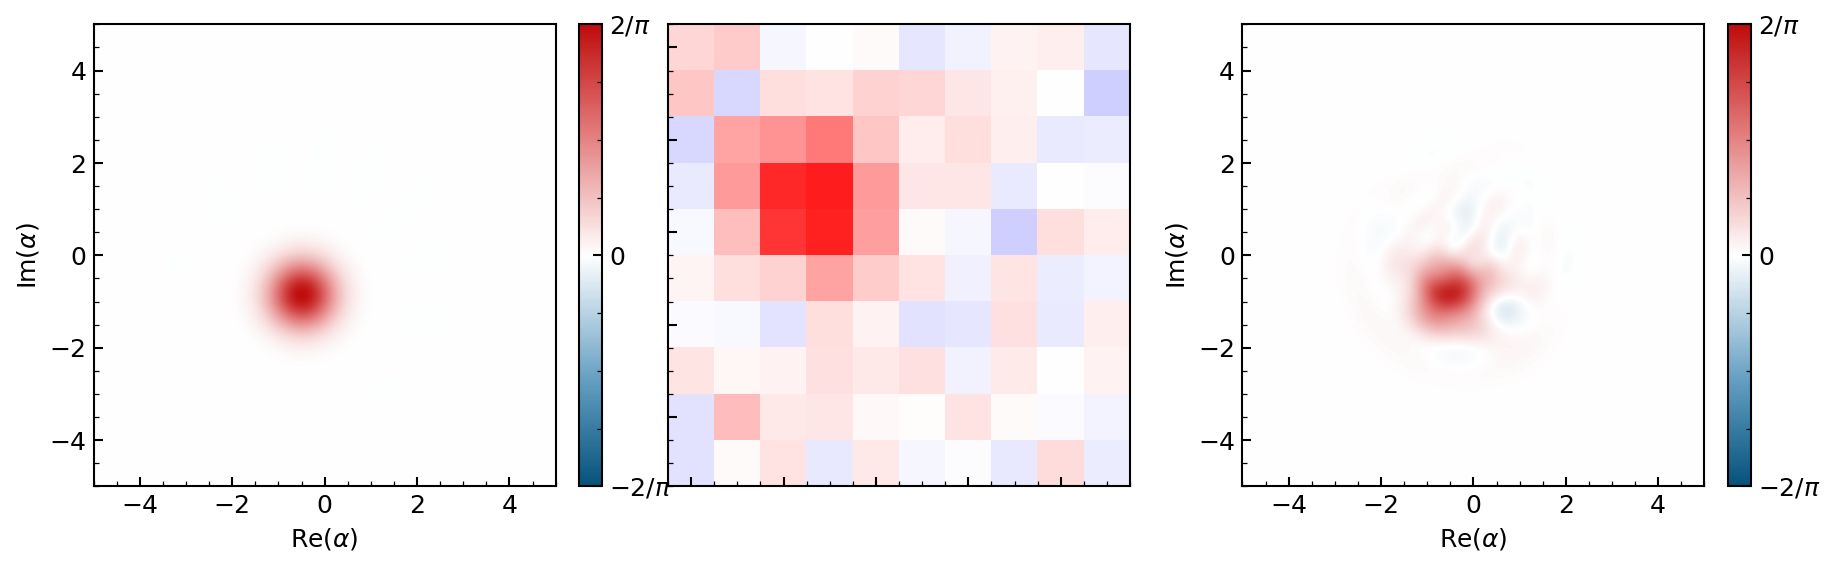

In [60]:
for coherent_state in coherentstates:
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    dq.plot.wigner(coherent_state, ax=axes[0])
    rho_out, fidelity = wigner_from_state_wnoise(coherent_state, x_vec, y_vec, sigma_test,axes)
    states = [coherent_state@dq.dag(coherent_state), rho_out]
    dq.plot.wigner(rho_out, ax=axes[2])
    print(fidelity)

0.8432906
0.8153993
0.8703174


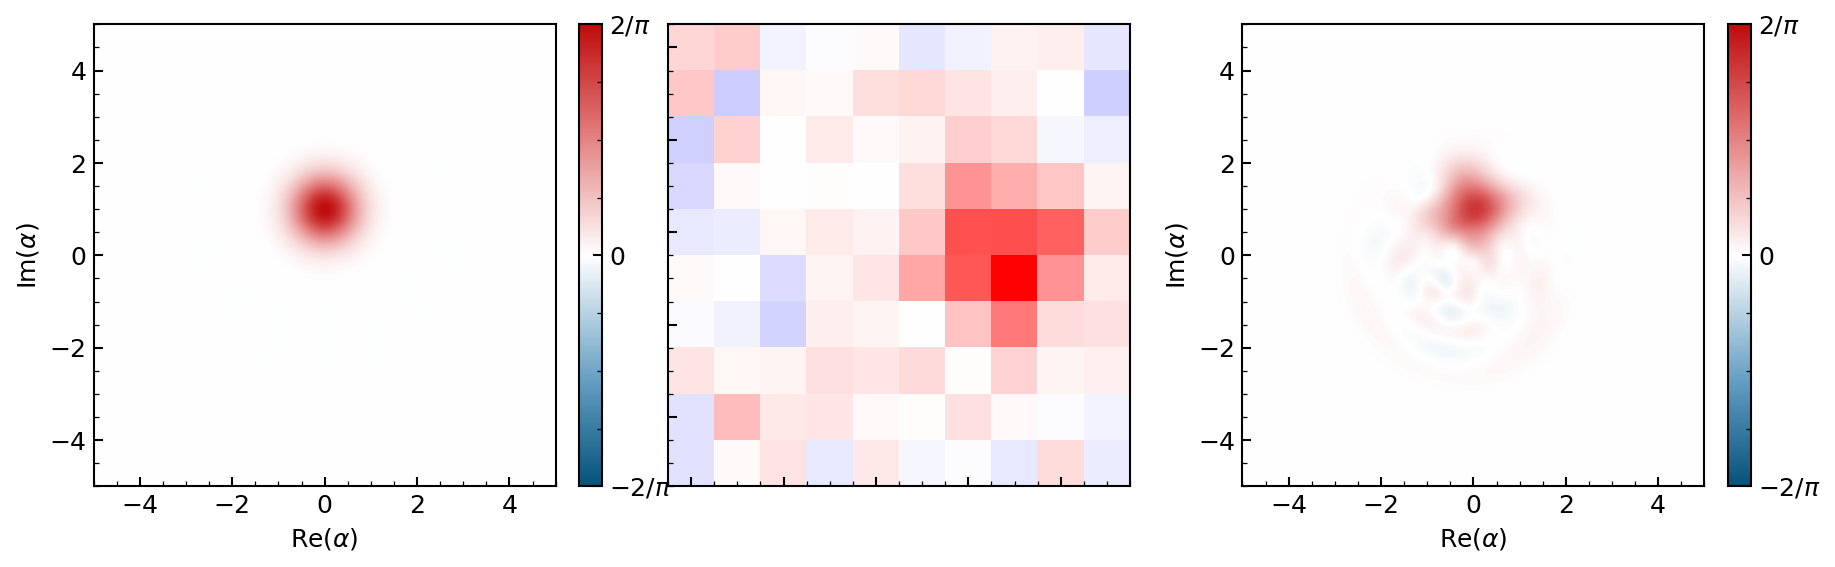

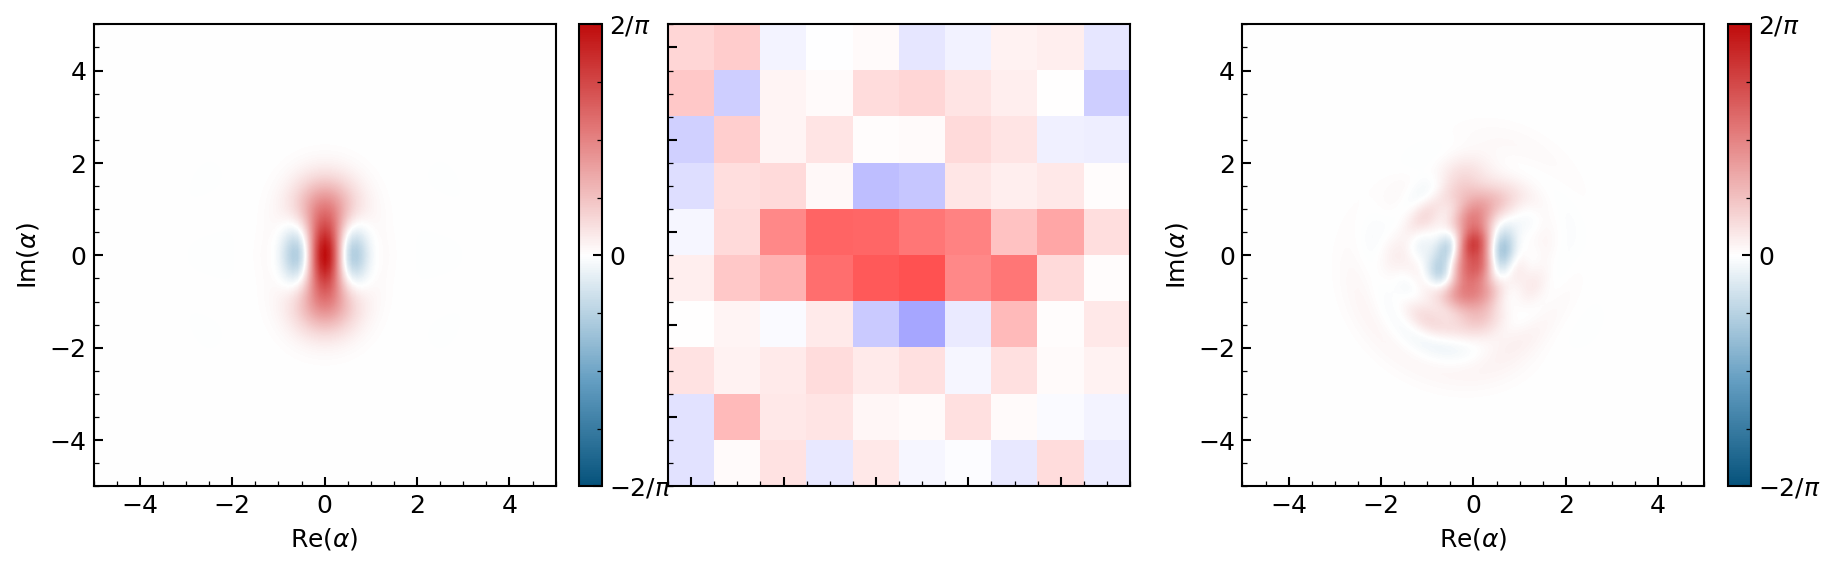

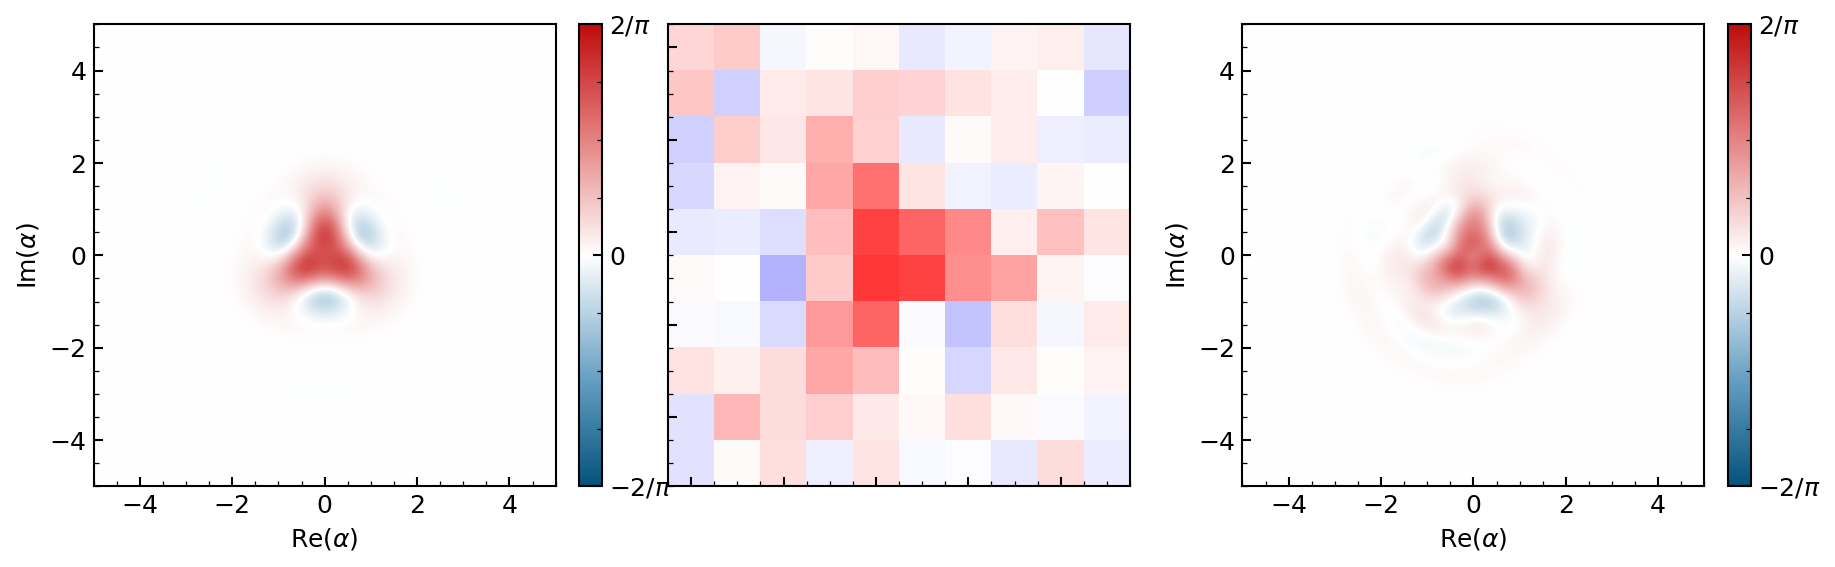

In [61]:
for cat_state in catstates:
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    dq.plot.wigner(cat_state, ax=axes[0])
    rho_out, fidelity = wigner_from_state_wnoise(cat_state, x_vec, y_vec, sigma_test,axes)
    states = [cat_state@dq.dag(cat_state), rho_out]
    dq.plot.wigner(rho_out, ax=axes[2])
    print(fidelity)

In [66]:
def add_gaussian_noise(wigner, sigma):
    noise = sigma*jax.random.normal(jax.random.key(0), wigner.shape)
    return jnp.add(wigner, noise)

def wigner_from_state_wnoise_2(rho_in,
           xv, yv,
           sigma,
           optimization_type = 'Least-Squares'
                            ):
    
    xv, yv = jnp.meshgrid(x_vec, y_vec)
    #Define Wigner Function
    def w(state, xv, xy):
        return jnp.pi/2*dq.wigner(state, xmax = xv.max(), ymax = yv.max(), npixels = len(xv))[2]
        
    #============================================================
    #Define Preliminary Data
    dim = rho_in.dims[0]
    if dim<5:
        fac = 10
    else:
        fac = 5
    
    #Check if dim has correct properties:
    if type(dim)!=int:
        raise('Dimension is not integer')
    
    #Compute measurement data
    w_k = add_gaussian_noise(w(rho_in, xv, yv), sigma).flatten()
    
    #Define Observables
    alpha = (xv.T + yv.T*1j).flatten()
    E_list = (dq.displace(dim*fac, alpha)@dq.parity(dim*fac)@dq.dag(dq.displace(dim*fac, alpha))).data[:, :dim, :dim]
    
    #===============================================================
    #Inititalize Optimization
    
    # Define variable
    rho = cp.Variable((dim, dim), hermitian=True)
    
    # Objective
    exprs = cp.hstack([cp.real(cp.trace(E@rho)) - k for E, k in zip(E_list, w_k)])
    
    if optimization_type == 'Least-Squares':
        objective = cp.Minimize(cp.sum_squares(exprs))
    if optimization_type == 'Huber':
        objective = cp.Minimize(cp.sum(cp.huber(exprs)))
    
    # print(objective)
    
    # Constraints
    constraints = [rho >> 0, cp.trace(rho) == 1]
    
    # Solve problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.MOSEK)
    
    # Output estimated density matrix
    rho_out = rho.value
    #Compute Fidelity
    fidelity = dq.fidelity(rho_in, rho_out)
    
    return fidelity

In [71]:
noise_list = [0.1*i for i in range(10)]
fock_list = [dq.fock(3 + i, 2) for i in range(10)]
fock_fidelities = [[wigner_from_state_wnoise_2(f, x_vec, y_vec, n) for n in noise_list] for f in fock_list]





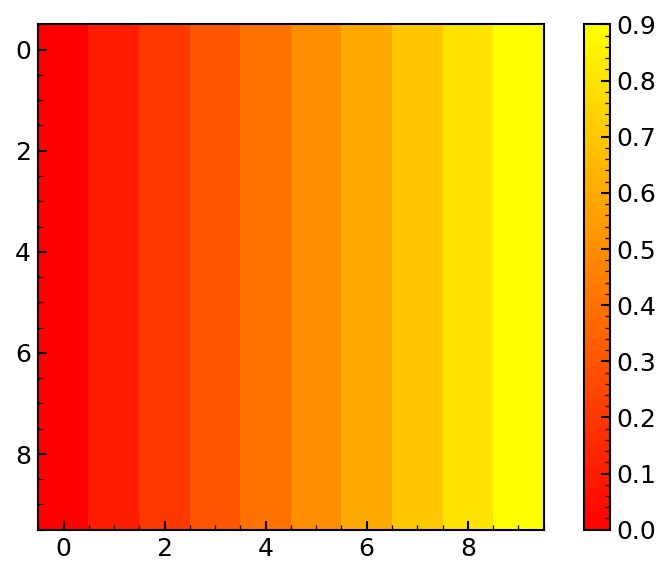

In [73]:
dfids = [[n for n in noise_list] for f in fock_list]
cplot = plt.imshow(dfids,cmap='autumn', interpolation='nearest')
plt.colorbar()
plt.show()

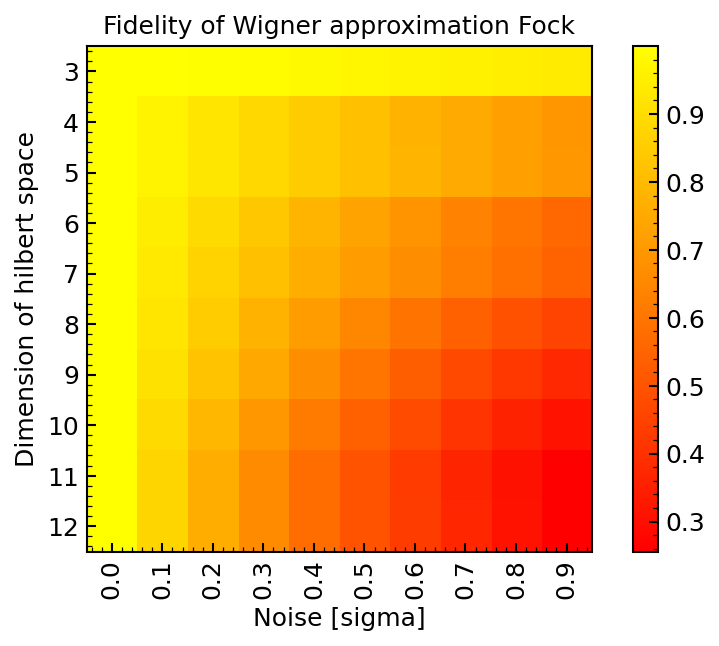

In [83]:
cplot = plt.imshow(fock_fidelities,cmap='autumn', interpolation='nearest')
plt.colorbar()
plt.xlabel("Noise [sigma]")
plt.ylabel("Dimension of hilbert space")
plt.title("Fidelity of Wigner approximation Fock")
plt.xticks(np.arange(10), [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], rotation = 90)
plt.yticks(np.arange(10), [3,4,5,6,7,8,9,10,11,12])
plt.savefig("Fockapprox")

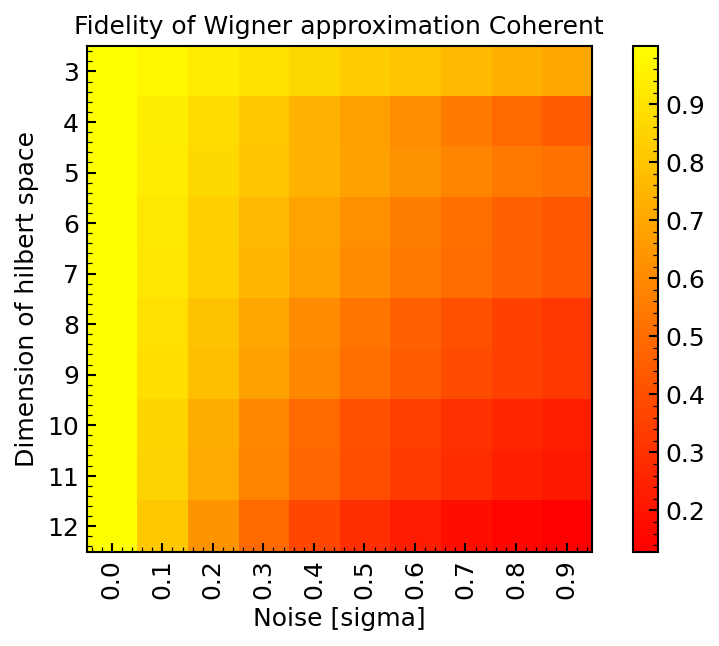

In [85]:
coherent_list = [dq.coherent(3 + i, 0) for i in range(10)]
coherent_fidelities = [[wigner_from_state_wnoise_2(f, x_vec, y_vec, n) for n in noise_list] for f in coherent_list]
cplot = plt.imshow(coherent_fidelities,cmap='autumn', interpolation='nearest')
plt.colorbar()
plt.xlabel("Noise [sigma]")
plt.ylabel("Dimension of hilbert space")
plt.title("Fidelity of Wigner approximation Coherent")
plt.xticks(np.arange(10), [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], rotation = 90)
plt.yticks(np.arange(10), [3,4,5,6,7,8,9,10,11,12])
plt.savefig("Coherentapprox")




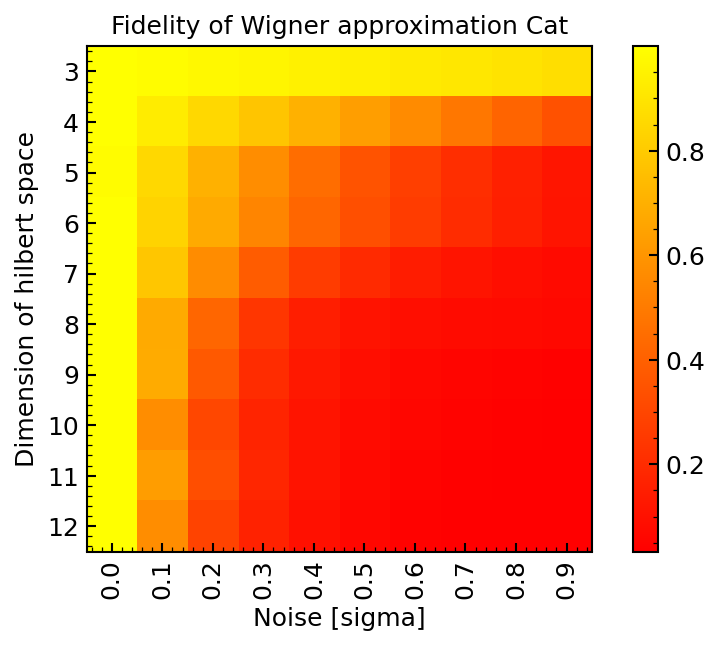

In [88]:
cat_list = [ncat(2, 2*np.exp(1j *PI/2),3 + i) for i in range(10)]
cat_fidelities = [[wigner_from_state_wnoise_2(f, x_vec, y_vec, n) for n in noise_list] for f in cat_list]
cplot = plt.imshow(cat_fidelities,cmap='autumn', interpolation='nearest')
plt.colorbar()
plt.xlabel("Noise [sigma]")
plt.ylabel("Dimension of hilbert space")
plt.title("Fidelity of Wigner approximation Cat")
plt.xticks(np.arange(10), [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], rotation = 90)
plt.yticks(np.arange(10), [3,4,5,6,7,8,9,10,11,12])
plt.savefig("Catapprox")
